In [1]:
import torch
import numpy as np
import torch.nn as nn

In [2]:
DATASET_PATH = "../data"
CHECKPOINT_PATH = "../saved_models/T3"

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [3]:
import urllib.request
from urllib.error import HTTPError
import os
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial3/"

pretrained_files = ["FashionMNIST_elu.config", "FashionMNIST_elu.tar",
                    "FashionMNIST_leakyrelu.config", "FashionMNIST_leakyrelu.tar",
                    "FashionMNIST_relu.config", "FashionMNIST_relu.tar",
                    "FashionMNIST_sigmoid.config", "FashionMNIST_sigmoid.tar",
                    "FashionMNIST_swish.config", "FashionMNIST_swish.tar",
                    "FashionMNIST_tanh.config", "FashionMNIST_tanh.tar"]
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f'downloading..{file_url}')
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("something went wrong..{e}")

In [4]:
class ActivationFunction(nn.Module):
    def __init__(self):
        super().__init__() 
        self.name = self.__class__.__name__
        self.config = {"name":self.name}

In [5]:
class Sigmoid(ActivationFunction):
    def forward(self, x):
        return 1/(1+torch.exp(-x))

In [6]:
sig = Sigmoid()
sig.config, sig.name, sig.forward(torch.tensor(2))

({'name': 'Sigmoid'}, 'Sigmoid', tensor(0.8808))

In [7]:
class Tanh(ActivationFunction):
    def forward(self, x):
        exp, neg_exp = torch.exp(x), torch.exp(-x)
        return (exp-neg_exp)/(exp+neg_exp) 

In [8]:
class Relu(ActivationFunction):
    def forward(self, x):
        return x * (x>0).float()
relu = Relu()
relu.forward(torch.Tensor([20,1,-8]))

tensor([20.,  1., -0.])

In [9]:
class LeakyRelu(ActivationFunction):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config['alpha'] = alpha
    def forward(self, x):
        return torch.where(x > 0, x , x*self.config['alpha'])
    
lr = LeakyRelu()
lr.forward(torch.Tensor([20,1,-8]))

tensor([20.0000,  1.0000, -0.8000])

In [10]:
t = torch.Tensor([20,1,-8])

In [11]:
class ELU(ActivationFunction):
    def forward(self, x):
        return torch.where(x>0, x, torch.exp(x)-1)
elu = ELU()
elu.forward(t), elu(t)


(tensor([20.0000,  1.0000, -0.9997]), tensor([20.0000,  1.0000, -0.9997]))

In [12]:
class Swish(ActivationFunction):
    def forward(self, x):
        return x*torch.sigmoid(x)

In [13]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": Relu,   
    "leakyrelu": LeakyRelu,
    "elu": ELU,
    "swish": Swish
}

In [14]:
def get_grads(act_fn, x):
    x = x.clone().requires_grad_()
    out = act_fn(x)
    out.sum().backward()
    # print(x.grad)
    return x.grad

In [15]:
get_grads(Swish(), t)

tensor([ 1.0000,  0.9277, -0.0023])

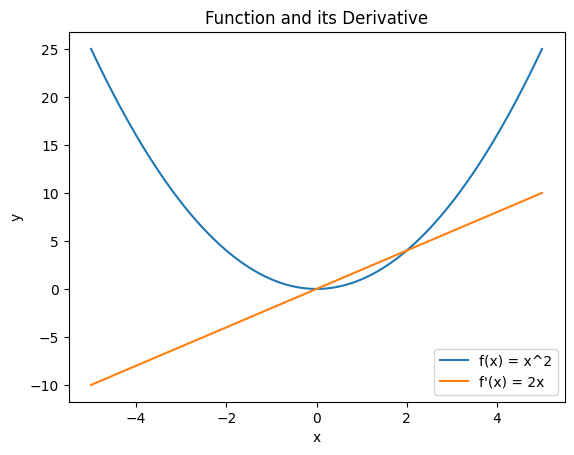

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Define the function and its derivative
def f(x):
    return x ** 2

def f_prime(x):
    return 2 * x

# Generate x values
x = np.linspace(-5, 5, 100)

# Calculate y values for the function and its derivative
y = f(x)
y_prime = f_prime(x)

# Create a figure and an axes object
fig, ax = plt.subplots()

# Plot the function and its derivative using the axes object
ax.plot(x, y, label="f(x) = x^2")
ax.plot(x, y_prime, label="f'(x) = 2x")

# Add a legend and titles
ax.legend()
ax.set_title("Function and its Derivative")
ax.set_xlabel("x")
ax.set_ylabel("y")

# Display the plot
plt.show()


In [17]:
t = torch.linspace(-5,5,1000)

In [18]:
def vis_act_fn(act_fn, ax, x):
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ax.plot(x,y, label="act_fn")
    ax.plot(x,y_grads, label="grad")
    ax.legend()
    ax.set_title(act_fn.name)
    ax.set_ylim(-1.5, x.max())

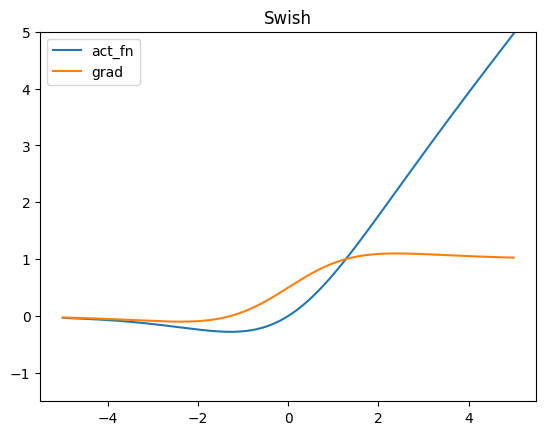

In [19]:
fig, ax = plt.subplots()
vis_act_fn(Swish(), ax, t)

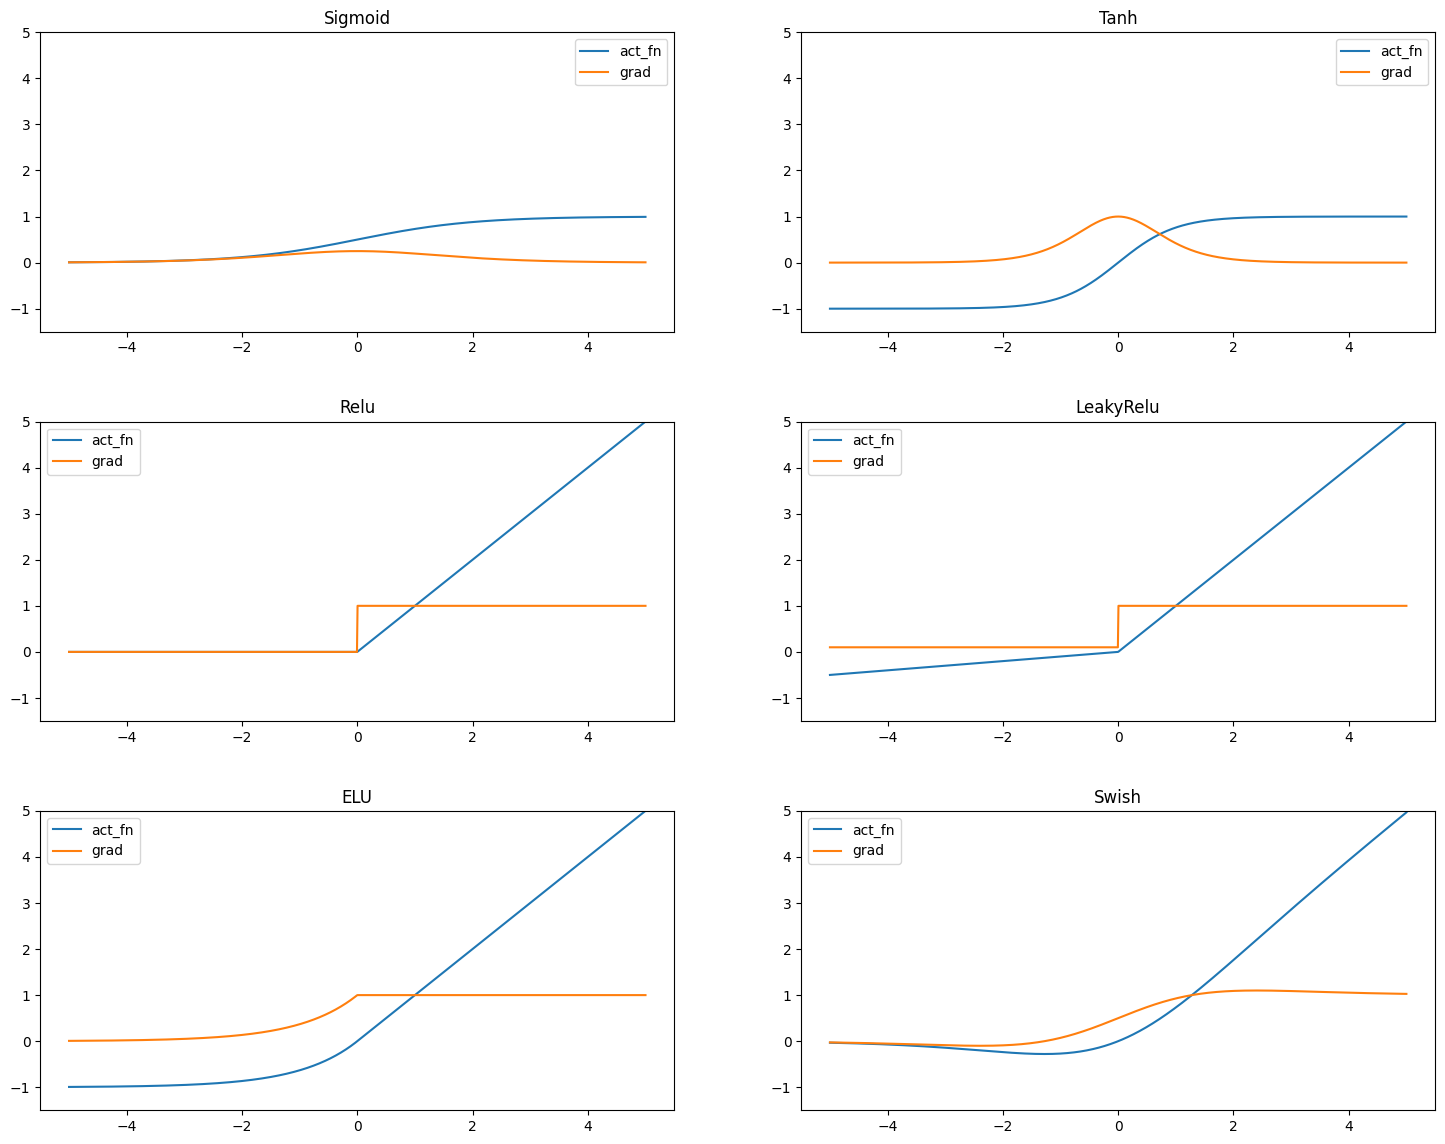

In [20]:
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
# act_fns 
fig, ax = plt.subplots(3, 2, figsize=(18, 14))
ax
for idx, act_fn in enumerate(act_fns):
    ax_idx = divmod(idx,2)
    vis_act_fn(act_fn, ax[ax_idx], t) 
fig.subplots_adjust(hspace=0.3)
plt.show()

Model creation


In [21]:
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        super().__init__()
        layers = []
        layers_size = [input_size] + hidden_sizes
        for layer_idx in range(1, len(layers_size)):
            layers += [nn.Linear(layers_size[layer_idx-1], layers_size[layer_idx]), act_fn]
        layers += [nn.Linear(layers_size[-1], num_classes)] 
        self.layers = nn.Sequential(*layers)
        self.config = {'act_fn':act_fn.config, 'input_size':input_size, 'num_classes':num_classes, 'hidden_sizes':hidden_sizes}
        print(self.config)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        # x = torch.einsum('ijk->i', x)
        # print(x)
        out = self.layers(x)
        return out

In [22]:
bn = BaseNetwork(LeakyRelu(), 768, 10, [256, 512, 768, 256])
bn.layers

{'act_fn': {'name': 'LeakyRelu', 'alpha': 0.1}, 'input_size': 768, 'num_classes': 10, 'hidden_sizes': [256, 512, 768, 256]}


Sequential(
  (0): Linear(in_features=768, out_features=256, bias=True)
  (1): LeakyRelu()
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): LeakyRelu()
  (4): Linear(in_features=512, out_features=768, bias=True)
  (5): LeakyRelu()
  (6): Linear(in_features=768, out_features=256, bias=True)
  (7): LeakyRelu()
  (8): Linear(in_features=256, out_features=10, bias=True)
)

In [23]:
x = torch.randint(1,5, (768,5,6), dtype=torch.float32)
x.dtype
# x
# y = x.view(x.size(0), -1)
# x.shape,y.shape

torch.float32

In [24]:
bn(x)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (768x30 and 768x256)

In [ ]:
import torch.utils.data as data
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.5,), (.5,))])
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

train_dataloader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
test_dataloader = data.DataLoader(test_set, batch_size=1024, shuffle=True, drop_last=False)
val_dataloader = data.DataLoader(val_set, batch_size=1024, shuffle=True, drop_last=False)


In [ ]:
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(49, 10, 10)

In [ ]:
train_set[0][1]

0

In [ ]:
exp_img = [train_set[i][0] for i in range(16)]
torch.stack(exp_img, dim=0).shape

torch.Size([16, 1, 28, 28])

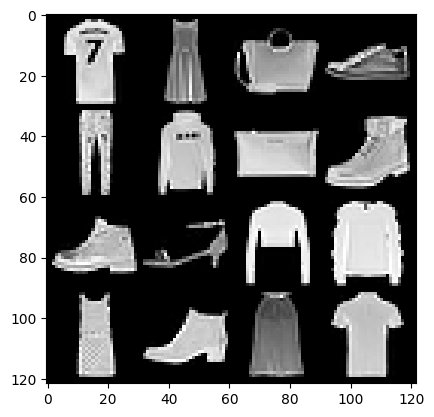

In [ ]:
img_grid = torchvision.utils.make_grid(torch.stack(exp_img, dim=0), nrow=4, normalize=True).permute(1,2,0)
plt.imshow(img_grid)

In [ ]:
import json
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name+".config")
def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name+".tar")

def load_model(model_path, model_name, net=None):
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    # print(config_file, model_file)
    assert os.path.isfile(config_file), f"The file does not exist"
    assert os.path.isfile(model_file), f"The file does not exist"
    with open(config_file, "r") as file:
        config_dict = json.load(file)
        print(config_dict)
    if net is None:
        # def __init__(self, act_fn, input_size, num_classes, hidden_sizes):
        act_fn = config_dict.pop('act_fn').pop('name').lower()
        print(act_fn, act_fn_by_name[act_fn], config_dict)
        net = BaseNetwork(act_fn_by_name[act_fn](), **config_dict)
    net.load_state_dict(torch.load(model_file, map_location=device))

def save_model(model, model_path, model_name):
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, 'w') as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)    

In [ ]:
MODEL_PATH = "../saved_models/T3"
MODEL_NAME = "FashionMNIST_relu"
device

device(type='cuda')

In [ ]:
load_model(MODEL_PATH, MODEL_NAME)

{'act_fn': {'name': 'ReLU'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}
relu <class '__main__.Relu'> {'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}
{'act_fn': {'name': 'Relu'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}


In [ ]:
import torch.nn.functional as F
def visualize_gradients(net, color="C0"):
    net.eval()
    small_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    print(imgs.shape, labels.shape)
    net.to(device)
    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    # print(net.named_parameters())
    # for names, params in net.named_parameters():
    #     print(names, params.shape)
    #     print(params.grad.data.view(-1).cpu().clone().numpy())
    grads = {name: params.grad.data.view(-1).cpu().clone().numpy() for name, params in net.named_parameters() if "weight" in name}
    grads1 = {name: params for name, params in net.named_parameters() if "weight" in name}
    # print(grads)
    print(grads1)
    net.zero_grad()



In [ ]:
net = BaseNetwork(Relu())
visualize_gradients(net)

{'act_fn': {'name': 'Relu'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}
torch.Size([256, 1, 28, 28]) torch.Size([256])
{'layers.0.weight': Parameter containing:
tensor([[-0.0029,  0.0326, -0.0332,  ...,  0.0259,  0.0275, -0.0181],
        [ 0.0119, -0.0014,  0.0288,  ...,  0.0230, -0.0169,  0.0015],
        [-0.0055,  0.0267, -0.0254,  ...,  0.0079,  0.0201,  0.0295],
        ...,
        [-0.0100, -0.0336,  0.0035,  ..., -0.0155, -0.0153, -0.0143],
        [ 0.0100,  0.0069,  0.0145,  ..., -0.0314,  0.0113, -0.0042],
        [ 0.0171, -0.0333,  0.0138,  ..., -0.0027, -0.0237, -0.0216]],
       device='cuda:0', requires_grad=True), 'layers.2.weight': Parameter containing:
tensor([[-0.0102, -0.0142, -0.0277,  ..., -0.0427, -0.0113, -0.0008],
        [ 0.0094, -0.0386, -0.0227,  ..., -0.0120, -0.0057,  0.0106],
        [-0.0062,  0.0399,  0.0213,  ...,  0.0176,  0.0175, -0.0410],
        ...,
        [-0.0002, -0.0076, -0.0362,  ..., -0.0083, -0.0391,  0.